# import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.executable

'/users/samova/lcances/.miniconda3/envs/pytorch-dev/bin/python'

In [3]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NU M_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"
import time

import numpy
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch.cuda.amp import autocast
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

from torchlibrosa.augmentation import SpecAugmentation

In [4]:
from SSL.util.model_loader import load_model
from SSL.util.loaders import load_dataset, load_optimizer, load_callbacks, load_preprocesser
from SSL.util.checkpoint import CheckPoint, mSummaryWriter
from SSL.util.utils import reset_seed, get_datetime, track_maximum, DotDict
from SSL.util.mixup import get_mixup_fn

from metric_utils.metrics import BinaryAccuracy, FScore, ContinueAverage

# Arguments

In [5]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--from_config", default="", type=str)
parser.add_argument("-d", "--dataset_root", default="../datasets", type=str)
parser.add_argument("-D", "--dataset", default="audioset-unbalanced", type=str)

group_t = parser.add_argument_group("Commun parameters")
group_t.add_argument("-m", "--model", default="wideresnet28_2", type=str)
group_t.add_argument("--supervised_ratio", default=1.0, type=float)
group_t.add_argument("--batch_size", default=128,type=int)
group_t.add_argument("--nb_epoch", default=15, type=int)
group_t.add_argument("--learning_rate", default=0.001, type=float)
group_t.add_argument("--resume", action="store_true", default=False)
group_t.add_argument("--seed", default=1234, type=int)

group_mixup = parser.add_argument_group("Mixup parameters")
group_mixup.add_argument("--mixup", action="store_true", default=False)
group_mixup.add_argument("--mixup_alpha", type=float, default=0.4)
group_mixup.add_argument("--mixup_max", action="store_true", default=False)
group_mixup.add_argument("--mixup_label", action="store_true", default=False)

group_sa = parser.add_argument_group("Spec augmentation")
group_sa.add_argument("--specAugment", action="store_true", default=False)
group_sa.add_argument("--sa_time_drop_width", type=int, default=32)
group_sa.add_argument('--sa_time_stripes_mum', type=int, default=2)
group_sa.add_argument("--sa_freq_drop_width", type=int, default=4)
group_sa.add_argument("--sa_freq_stripes_num", type=int, default=2)

group_u = parser.add_argument_group("Datasets parameters")
group_u.add_argument("-t", "--train_folds", nargs="+", default=[1, 2, 3, 4], type=int)
group_u.add_argument("-v", "--val_folds", nargs="+", default=[5], type=int)

group_l = parser.add_argument_group("Logs")
group_l.add_argument("--checkpoint_root", default="../model_save/", type=str)
group_l.add_argument("--tensorboard_root", default="../tensorboard/", type=str)
group_l.add_argument("--checkpoint_path", default="supervised", type=str)
group_l.add_argument("--tensorboard_path", default="supervised", type=str)
group_l.add_argument("--log_suffix", default="", type=str)

parser.add_argument("-N", "--nb_gpu", default=1, type=int)


args = parser.parse_args("")

args.tensorboard_path = os.path.join(args.tensorboard_root, args.dataset, args.tensorboard_path)
args.checkpoint_path = os.path.join(args.checkpoint_root, args.dataset, args.checkpoint_path)

In [6]:
vars(args)

{'from_config': '',
 'dataset_root': '../datasets',
 'dataset': 'audioset-unbalanced',
 'model': 'wideresnet28_2',
 'supervised_ratio': 1.0,
 'batch_size': 128,
 'nb_epoch': 15,
 'learning_rate': 0.001,
 'resume': False,
 'seed': 1234,
 'mixup': False,
 'mixup_alpha': 0.4,
 'mixup_max': False,
 'mixup_label': False,
 'specAugment': False,
 'sa_time_drop_width': 32,
 'sa_time_stripes_mum': 2,
 'sa_freq_drop_width': 4,
 'sa_freq_stripes_num': 2,
 'train_folds': [1, 2, 3, 4],
 'val_folds': [5],
 'checkpoint_root': '../model_save/',
 'tensorboard_root': '../tensorboard/',
 'checkpoint_path': '../model_save/audioset-unbalanced/supervised',
 'tensorboard_path': '../tensorboard/audioset-unbalanced/supervised',
 'log_suffix': '',
 'nb_gpu': 1}

# initialisation

In [7]:
reset_seed(args.seed)


trainer = SupervisedTrainer("cnn03", "esc10")
trainer.init_trainer(
    parameters=vars(args),
    seed = args.seed,
    num_workers=0,
    pin_memory=True,
    verbose = 2
)

In [8]:
# from SSL.trainers.esc import SupervisedTrainer
from SSL.trainers.trainers import Trainer

class SupervisedTrainer(Trainer):
    def __init__(self, model: str, dataset: str):
        super().__init__(model, "supervised", dataset)

trainer = SupervisedTrainer(args.model, args.dataset)

# Prepare the dataset

In [9]:
trainer.load_transforms()

Load the transformation


/usr/local/PyTorch/audio/torchaudio/extension/extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


In [10]:
parameters = dict(
    dataset=args.dataset,

    dataset_root = args.dataset_root,
    supervised_ratio = args.supervised_ratio,
    batch_size = args.batch_size * args.nb_gpu,
    train_folds = args.train_folds,
    val_folds = args.val_folds,
    
    num_workers=10,
    pin_memory=True,

    verbose = 2,
)

trainer.load_dataset(parameters)

Load the dataset
______
eva
['eval.h5']
______
unb
['unbalanced_train_part08.h5', 'unbalanced_train_part02.h5', 'unbalanced_train_part05.h5', 'unbalanced_train_part10.h5', 'unbalanced_train_part01.h5', 'unbalanced_train_part03.h5', 'unbalanced_train_part07.h5', 'unbalanced_train_part06.h5', 'unbalanced_train_part09.h5', 'unbalanced_train_part04.h5']


# Prep model

In [11]:
from types import MethodType
from torch.cuda import empty_cache
from torchsummary import summary


def create_model(self, nb_gpu: int = 1):
    print("Create the model")
    empty_cache()

    model_func = load_model(self.dataset, self.model_str)
    self.model = model_func(
        input_shape=self.input_shape,
        num_classes=self.num_classes,
    )
    self.model = self.model.cuda()
    
    if nb_gpu > 1:
        self.model = nn.DataParallel(self.model)

    s = summary(self.model, self.input_shape)
    
trainer.create_model = MethodType(create_model, trainer)
trainer.create_model(args.nb_gpu)

Create the model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 64, 500]             288
       BatchNorm2d-2          [-1, 32, 64, 500]              64
              ReLU-3          [-1, 32, 64, 500]               0
         MaxPool2d-4          [-1, 32, 32, 250]               0
            Conv2d-5          [-1, 32, 32, 250]           9,216
       BatchNorm2d-6          [-1, 32, 32, 250]              64
              ReLU-7          [-1, 32, 32, 250]               0
            Conv2d-8          [-1, 32, 32, 250]           9,216
       BatchNorm2d-9          [-1, 32, 32, 250]              64
             ReLU-10          [-1, 32, 32, 250]               0
       BasicBlock-11          [-1, 32, 32, 250]               0
           Conv2d-12          [-1, 32, 32, 250]           9,216
      BatchNorm2d-13          [-1, 32, 32, 250]              64
             ReLU-14  

# Training initialization

## Losses

In [12]:
def init_loss(self):
    self.loss_ce = nn.BCEWithLogitsLoss(reduction="mean")

trainer.init_loss = MethodType(init_loss, trainer)

In [13]:
trainer.init_loss()

## optimizer & callbacks

In [14]:
parameters=DotDict(
    learning_rate=args.learning_rate,
)
trainer.init_optimizer(parameters)


Initialize optimizer


In [15]:
parameters=DotDict(
    nb_epoch=args.nb_epoch,
    optimizer=trainer.optimizer,
)
trainer.init_callbacks(parameters)

Initialize callbacks


# Logs and checkpoint

In [16]:
# Logs
parameters=DotDict(
    supervised_ratio=args.supervised_ratio
)
trainer.init_logs(parameters, suffix=args.log_suffix)

Prepare the log system


In [21]:
# Checkpoint
parameters=DotDict(
    supervised_ratio=args.supervised_ratio
)
trainer.init_checkpoint(parameters, suffix=args.log_suffix)

Prepare the checkpoint system
checkpoint initialise at:  /users/samova/lcances/semi-supervised/model_save/audioset-unbalanced/supervised/wideresnet28_2/1.0S/wideresnet28_2_1.0S
name:  wideresnet28_2_1.0S
mode:  max


## Metrics

In [ ]:
# Metrics
def init_metrics(self):
    self.metrics = DotDict(
        fscore_fn=FScore(),
        acc_fn=BinaryAccuracy(),
        avg_fn=ContinueAverage(),
    )
    self.maximum_tracker = track_maximum()

trainer.init_metrics = MethodType(init_metrics, trainer)
trainer.init_metrics()

## training function

In [ ]:
def set_printing_form(self):
    UNDERLINE_SEQ = "\033[1;4m"
    RESET_SEQ = "\033[0m"

    header_form = "{:<8.8} {:<6.6} - {:<6.6} - {:<8.8} {:<6.6} - {:<9.9} {:<12.12}| {:<9.9}- {:<6.6}"
    value_form  = "{:<8.8} {:<6} - {:<6} - {:<8.8} {:<6.4f} - {:<9.9} {:<10.4f}| {:<9.4f}- {:<6.4f}"

    self.header = header_form.format(
        ".               ", "Epoch", "%", "Losses:", "ce", "metrics: ", "acc", "F1 ","Time"
    )

    self.train_form = value_form
    self.val_form = UNDERLINE_SEQ + value_form + RESET_SEQ

# init mixup and SpecAugment

In [ ]:
# Spec augmenter
spec_augmenter = SpecAugmentation(time_drop_width=args.sa_time_drop_width,
                                  time_stripes_num=args.sa_time_stripes_mum,
                                  freq_drop_width=args.sa_freq_drop_width,
                                  freq_stripes_num=args.sa_freq_stripes_num)
spec_augmenter = spec_augmenter.cuda()

# Mixup
mixup_fn = get_mixup_fn(alpha=args.mixup_alpha, use_max=args.mixup_max, mix_label=args.mixup_label)

In [ ]:
batch_summed = []

args.specAugment = True
args.mixup = True

def train_fn(self, epoch: int):
    # aliases
    M = self.metrics
    T = self.tensorboard.add_scalar
    nb_batch = len(self.train_loader)

    start_time = time.time()
    print("")

    self.reset_metrics()
    self.model.train()

    for i, (X, y) in enumerate(self.train_loader):
        
        if args.specAugment:
            X = X.view(-1, 1, *X.shape[1:])
            X = spec_augmenter(X)
            X = X.squeeze(1)

        if args.mixup:
            X, y = mixup_fn(X, y)
        
        X = X.cuda().float()
        y = y.cuda().float()
        
        
        # Skip the mini batch if the ratio is not satisfactory
        # The files are in the batch_balancer so they will be used but later
        with torch.set_grad_enabled(False):
            summed = torch.sum(y, axis=0)
            summed = summed[summed > 0]
            ratio = min(summed) / max(summed)
            if ratio < 0.5:
                continue
        
        logits = self.model(X)
        loss = self.loss_ce(logits, y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        with torch.set_grad_enabled(False):
            acc = M.acc_fn(logits, y).mean
            fscore = M.fscore_fn(logits, y).mean
            avg_ce = M.avg_fn(loss.item()).mean
            
            summed = torch.sum(y, axis=0)
            batch_summed.append(summed)

            # logs
            print(self.train_form.format(
                "Training: ",
                epoch + 1,
                int(100 * (i + 1) / nb_batch),
                "", avg_ce,
                "", acc, fscore,
                time.time() - start_time
            ), end="\r")

    T("train/Lce", avg_ce, epoch)
    T("train/f1", fscore, epoch)
    T("train/acc", acc, epoch)

In [ ]:
def val_fn(self, epoch: int):
    # aliases
    M = self.metrics
    T = self.tensorboard.add_scalar
    nb_batch = len(self.val_loader)

    start_time = time.time()
    print("")

    self.reset_metrics()
    self.model.eval()

    with torch.set_grad_enabled(False):
        for i, (X, y) in enumerate(self.val_loader):
            X = X.cuda().float()
            y = y.cuda().float()

            logits = self.model(X)
            loss = self.loss_ce(logits, y)

            acc = M.acc_fn(logits, y).mean
            fscore = M.fscore_fn(logits, y).mean
            avg_ce = M.avg_fn(loss.item()).mean

            # logs
            print(self.val_form.format(
                "Validation: ",
                epoch + 1,
                int(100 * (i + 1) / nb_batch),
                "", avg_ce,
                "", acc, fscore,
                time.time() - start_time
            ), end="\r")

    T("val/Lce", avg_ce, epoch)
    T("val/f1", fscore, epoch)
    T("val/acc", acc, epoch)

    T("hyperparameters/learning_rate", self._get_lr(), epoch)

    T("max/acc", self.maximum_tracker("acc", acc), epoch)
    T("max/f1", self.maximum_tracker("f1", fscore), epoch)

    self.checkpoint.step(fscore)
    for c in self.callbacks:
        c.step()
        pass

In [ ]:
def test_fn(self):
    # aliases
    M = self.metrics
    T = self.tensorboard.add_scalar
    nb_batch = len(self.val_loader)

    # Load best epoch
    self.checkpoint.load_best()

    start_time = time.time()
    print("")

    self.reset_metrics()
    self.model.eval()

    with torch.set_grad_enabled(False):
        for i, (X, y) in enumerate(self.test_loader):
            X = X.cuda()
            y = y.cuda()

            logits = self.model(X)
            loss = self.loss_ce(logits, y)

            acc = M.acc_fn(pred_arg, y).mean
            fscore = M.fscore_fn(pred, y).mean
            avg_ce = M.avg_fn(loss.item()).mean

            # logs
            print(self.val_form.format(
                "Testing: ",
                1,
                int(100 * (i + 1) / nb_batch),
                "", avg_ce,
                "", acc, fscore,
                time.time() - start_time
            ), end="\r")

In [ ]:
trainer.set_printing_form = MethodType(set_printing_form, trainer)
trainer.train_fn = MethodType(train_fn, trainer)
trainer.val_fn = MethodType(val_fn, trainer)
trainer.test_fn = MethodType(test_fn, trainer)

# Training

In [ ]:
# Resume if wish
if args.resume:
    trainer.checkpoint.load_last()

In [ ]:
# Fit function
trainer.set_printing_form()
print(trainer.header)

start_epoch = trainer.checkpoint.epoch_counter
end_epoch = args.nb_epoch

for e in range(start_epoch, args.nb_epoch):
    trainer.train_fn(e)
    trainer.val_fn(e)
    
    trainer.tensorboard.flush()

In [ ]:
batch_summed_ = batch_summed.copy()
ratio = []

for i in range(len(batch_summed)):
    batch = batch_summed_[i].cpu()
    batch = batch[batch > 0]
    
    ratio.append(min(batch) / max(batch))

In [ ]:
import matplotlib.pyplot as plt

plt.figure(0, figsize=(20,5))
plt.plot(ratio)

plt.show()

In [28]:
if args.dataset.lower() == "speechcommand":
    trainer.test_fn()

# display

KeyError: 'val/acc'

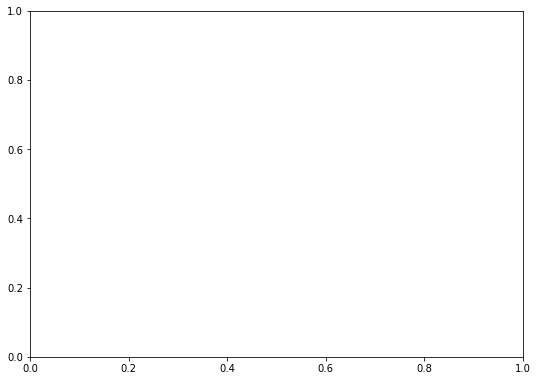

In [62]:
import matplotlib.pyplot as plt
import numpy as np

T=trainer.tensorboard.history

x = list(range(trainer.checkpoint.epoch_counter))
sm = lambda y, w: np.convolve(y, np.ones(w)/w, mode='same')
pp = lambda k: plt.plot(x, T[k], label=f"{k} = {max(T[k])}")
spp = lambda k: plt.plot(x, sm(T[k], 5), label=f"{k} = {max(T[k])}")


plt.figure(0, figsize=(30, 14))
plt.subplot(2, 3, 1)
pp("val/acc")
pp("val/f1")
plt.legend()

plt.subplot(2, 3, 2)
pp("hyperparameters/learning_rate")
plt.legend()

plt.subplot(2, 3, 3)
pp("max/acc")
plt.legend()

plt.show()

# ♫♪.ılılıll|̲̅̅●̲̅̅|̲̅̅=̲̅̅|̲̅̅●̲̅̅|llılılı.♫♪

# Compute mAP

In [58]:
trainer.checkpoint.load("/users/samova/lcances/semi-supervised/model_save/audioset-unbalanced/supervised/MobileNetV1/1.0S/MobileNetV1_1.0S.last")

['state_dict', 'optimizer', 'epoch', 'best_metric']
['state_dict', 'optimizer', 'epoch', 'best_metric']


In [59]:
from metric_utils.metrics import Precision, Recall

total_pred = []
total_targets = []

trainer.model.eval()

nb_batch = len(trainer.val_loader)

S = nn.Sigmoid()

with torch.set_grad_enabled(False):
    for i, (X, y) in enumerate(trainer.val_loader):
        X = X.cuda().float()
        y = y.cuda().float()

        logits = trainer.model(X)
        
        total_pred.append(S(logits).cpu())
        total_targets.append(y.cpu())
        
        print("%d / %d" % (i, nb_batch), end="\r")

In [60]:
total_pred_ = numpy.vstack(total_pred)
total_targets_ = numpy.vstack(total_targets)

In [61]:
len(total_targets_), len(total_pred)

(20224, 79)

In [62]:
from sklearn import metrics
import tqdm

In [63]:
mAP = metrics.average_precision_score(total_targets_, total_pred_, average=None)

In [64]:
mAP.mean()

0.004273859528499027

In [65]:
with open("/projets/samova/leocances/AudioSet/hdfs/mel_64x500/class_labels_indices.csv") as f:
    lines = f.read().splitlines()[1:]
display_names = [", ".join(l.split(",")[2:])[1:-1] for l in lines]

In [66]:
import numpy as np
import matplotlib.pyplot as plt

NameError: name 'ordered_precision' is not defined

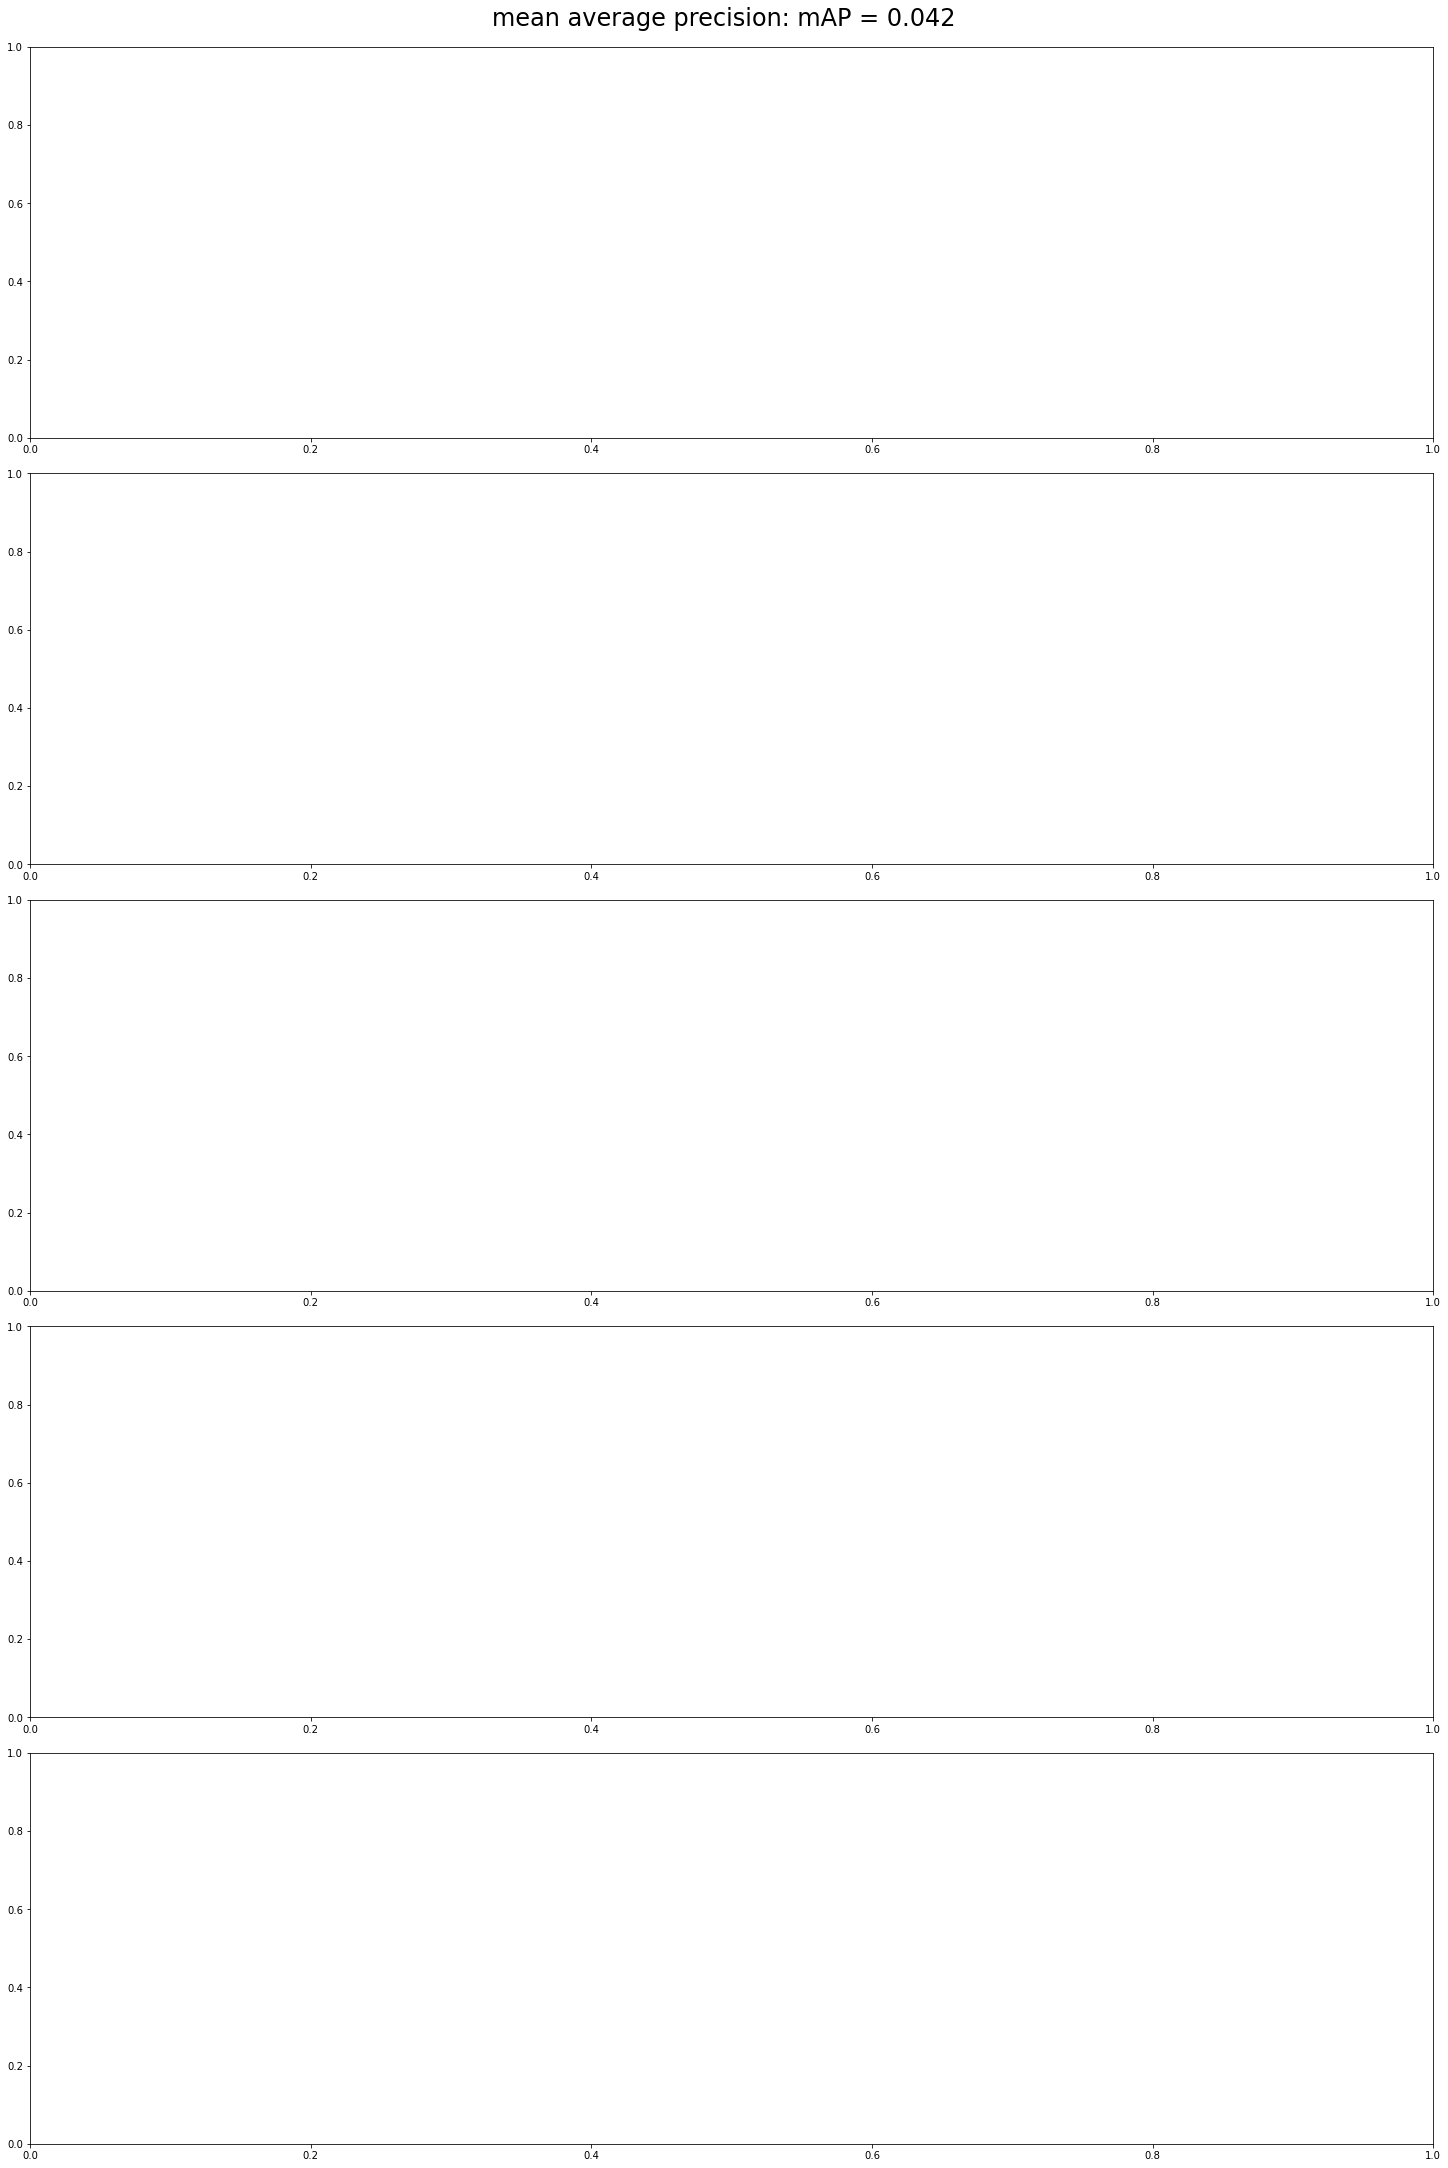

In [67]:
x = np.arange(527)

fig, axis = plt.subplots(nrows=5, figsize=(20,6*5), constrained_layout=True)
fig.suptitle("mean average precision: mAP = %.3f" % class_precision_fn.mean.mean().cpu(), fontsize=24)

for i in range(5):
    ax = axis[i]
    
    start = i * 100
    end = start + 100
    
    precision_chunk = ordered_precision[start:end]
    x = np.arange(100)
    
    ax.bar(x, height=precision_chunk)
    ax.set_ylim(0, 1)
    ax.set_xticks(x)
    ax.set_xticklabels(ordered_names[start:end], rotation=90)
    
fig.show()

In [ ]:
mAP = metrics.average_precision_score(target, clipwise_output, average=None)

# Computing mAUC

In [33]:
total_targets = numpy.vstack(total_targets)
total_pred = numpy.vstack(total_pred)

In [34]:
from sklearn import metrics

metrics_auc = []
for i in tqdm.tqdm(range(527)):
    y = total_targets[:,i]
    pred = total_pred[:,i]

    fpr, tpr, thresholds = metrics.roc_curve(y, pred)
    metrics_auc.append(metrics.auc(fpr, tpr))

100%|██████████| 527/527 [00:01<00:00, 283.86it/s]


In [35]:
numpy.mean(metrics_auc)


0.5125527444493218

# Computing d-prime
https://stats.stackexchange.com/questions/492673/understanding-and-implementing-the-dprime-measure-in-python

In [36]:
from scipy.stats import norm
Z = norm.ppf

def calc_dprime(y_true, y_pred):
    return numpy.sqrt(2) * Z(metrics.roc_auc_score(y_true,y_pred))

dprimes = []
for i in tqdm.tqdm(range(527)):
    y = total_targets[:,i]
    pred = total_pred[:,i]

    dprimes.append(calc_dprime(y, pred))

100%|██████████| 527/527 [00:03<00:00, 156.32it/s]


In [37]:
numpy.mean(dprimes)

0.05462639725994826

# Testing `fit` function from trainer.

In [33]:
from SSL.trainers import SupervisedTrainer

training_params=dict(
    dataset=args.dataset,

    dataset_root = args.dataset_root,
    supervised_ratio = args.supervised_ratio,
    batch_size = args.batch_size,
    train_folds = args.train_folds,
    val_folds = args.val_folds,
    learning_rate=args.learning_rate,
    nb_epoch=args.nb_epoch,
    seed=args.seed,

)
other_params = dict(
    num_workers=0,
    pin_memory=True,
    verbose = 2,
)

trainer = SupervisedTrainer("cnn03", "esc10")
trainer.init_trainer(
    training_params,
    **other_params
    
)

Load the transformation
Load the dataset
Dataset already downloaded and verified.
Dataset already downloaded and verified.
Create the model
1872 10
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 24, 64, 431]             240
         MaxPool2d-2          [-1, 24, 16, 215]               0
       BatchNorm2d-3          [-1, 24, 16, 215]              48
             ReLU6-4          [-1, 24, 16, 215]               0
            Conv2d-5          [-1, 48, 16, 215]          10,416
         MaxPool2d-6           [-1, 48, 4, 107]               0
       BatchNorm2d-7           [-1, 48, 4, 107]              96
             ReLU6-8           [-1, 48, 4, 107]               0
            Conv2d-9           [-1, 72, 4, 107]          31,176
        MaxPool2d-10            [-1, 72, 2, 53]               0
      BatchNorm2d-11            [-1, 72, 2, 53]             144
            ReLU6-1

In [ ]:
trainer.fit()

# Cross validation

In [ ]:
trainer = SupervisedTrainer("wideresnet28_2", "esc10")

train_folds = [[1, 2, 3, 4],
               [2, 3, 4, 5],
               [3, 4, 5, 1],
               [4, 5, 1, 2],
               [5, 1, 2, 3]]
val_folds = [[5], [1], [2], [3], [4]]

for tf, vf in zip(train_folds, val_folds):
    training_params["train_folds"] = tf
    training_params["val_folds"] = vf

    trainer.init_trainer(
        training_params,
        **other_params
    )

    trainer.fit()
    trainer.close()

# Grid search seed

In [3]:
import numpy as np
seeds = np.random.randint(10000, size=(1))
history = {}

trainer = SupervisedTrainer("wideresnet28_2", "esc10")

train_folds = [1, 2, 3, 4]
val_folds = [5]
seeds = np.random

for seed in seeds:
    training_params["train_folds"] = [1, 2, 3, 4]
    training_params["val_folds"] = [5]
    training_params["seed"] = seed

    trainer.init_trainer(
        training_params,
        **other_params
    )

    trainer.fit()

    history[seed] = trainer.maximum_tracker
    trainer.close()

NameError: name 'SupervisedTrainer' is not defined